# Introduzione

Come descritto in [Barlacchi et al.](https://www.nature.com/articles/sdata201555), il dataset qui utilizzato è composto di dati geografici, meteo, Twitter e dei consumi elettrici della Provincia autonoma di Trento tra il 01-11-2013 e il 31-12-2013.

- I **dati meteo** sono forniti da [MeteoTrentino](https://www.meteotrentino.it), e includono dati riguardanti il vento massimo e minimo, le precipitazioni massime e minime, la temperatura massima e minima di 37 stazioni localizzate sul territorio provinciale, oltre alle serie temporali registrate ogni dieci minuti della precipitazione e delle temperature per ogni giorno del periodo studiato per ogni cella individuata dal file `grid.csv`. A seguito di una pulizia dei dati abbiamo eliminato i dati storici e mediato tra minimo e massimo giornaliero per inserire come feature la `mean_temp`, `mean_prec` e `mean_wind`, rispettivamente temperatura media, precipitazione media e vento medio. Abbiamo associato inoltre ad ogni cella geografica i dati meteo della stazione geografica più vicina.
- I **dati della collocazione geografica** delle celle in `cellId` sono contenuti nel file `grid.csv`.
- I **dati di Twitter** sono stati aggregati per giorno e forniscono il conteggio totale di tweet inviati nel quadrante geografico preso in considerazione.
- I **dati dei consumi elettrici** (SET) del giorno precedente sono stati inseriti, cella geografica per cella geografica, come features da prendere in considerazione. Inoltre sono stati aggregati per fascia oraria: le colonne con la segnatura `pca` indicano il consumo del giorno precedente in fascia oraria 08:00-19:00, mentre le colonne con la segnatura `pcb` indicano il consumo del giorno precedente in fascia oraria 19:00. I dati del consumo elettrico totale del quadrante geografico considerato sono stati inseriti come target. Per far sì che ai dati del giorno precedente di consumo per cella corrispondessero i dati del giorno stesso del consumo cumulativo, abbiamo shiftato le colonne dei consumi del giorno precedente di un posto e quindi abbiamo perso un dato. Abbiamo scelto di non «imputare» il dato per non generare distorsioni e di eliminare direttamente la riga.

Abbiamo preparato precedentemente due DataFrames che importeremo usando la libreria `pickle`, che contengono rispettivamente i dataset dell'intero territorio della **Provincia autonoma di Trento** `dfA` e quello invece del solo territorio del **Comune di Trento** `dfB`. Per ricavare quest'ultimo abbiamo semplicemente estratto dal DataFrame più completo le features che corrispondevano ai consumi elettrici delle celle geografiche che rientravano nei confini amministrativi del Comune di Trento e abbiamo aggregato i dati delle restanti features limitatamente, sempre, alle celle geografiche nei confini amministrativi. I dati di questi confini li abbiamo presi dal dataset di [OpenPolis](https://github.com/openpolis/geojson-italy), scelti perché il dataset dei dati amministrativi fornito non ha l'elenco dei comuni aggiornato alle ultime fusioni e soppressioni (2020).

L'obiettivo della regressione è *cercare di predire i consumi di energia per la Provincia autonoma di Trento e per il Comune di Trento, date le informazioni che possediamo (temperatura, precipitazione e vento medio, conteggio di tweets, consumi elettrici del giorno precedente per tutte le celle geografiche)*.

# Importare le librerie e i datasets

Importiamo le librerie che utilizzeremo in tutta la seguente regressione.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

Importiamo i dati preparati in precedenza.

In [2]:
'''
Importo i dati per tutta la Provincia autonoma di Trento
'''
infile = open('data/tot_df.pkl','rb')
dfA = pickle.load(infile)
infile.close()

'''
Importo i dati per il Comune di Trento
'''
infile = open('data/tn_df.pkl','rb')
dfB = pickle.load(infile)
infile.close()

# Regressione: Provincia autonoma di Trento

## Divisione del dataset in set di training e di test

*First things first*: utilizziamo `train_test_split` della libreria `sklearn` per dividere il dataset in set di training e set di test. Impostiamo il set di test come il 20% del dataset, e impostiamo inoltre l'opzione `shuffle=False` per evitare che lo splitting avvenga in modo randomico. Questa accortezza, che adotteremo anche in altre parti di questa analisi, è necessaria per tenere conto della sequenzialità delle entrate del nostro dataset.

Da ora in poi utilizzeremo solo il set di training.

In [3]:
from sklearn.model_selection import train_test_split
trainA, testA = train_test_split(dfA, test_size=0.2, shuffle=False)

In [4]:
pat = trainA.drop(['pat_cons', 'tn_cons'], axis=1)
pat_labels = trainA['pat_cons'].copy()

In [5]:
trainA.head()

date  tweetcount   mean_prec  mean_wind  mean_temp     pca155  \
1 2013-11-02       209.0   37.168750    4775.95   69105.55  14.585304   
2 2013-11-03       203.0  744.205702    6716.35   63509.25  26.031270   
3 2013-11-04       180.0  272.649781    3346.50   40925.65  20.691523   
4 2013-11-05       285.0   11.035965    4068.45   56657.10  36.039039   
5 2013-11-06       206.0   30.890592    5293.40   58988.45  21.844423   

      pca272     pca273      pca276      pca277  ...  pcb10981  pcb10982  \
1  14.585304  14.585304   56.631025   56.631025  ...  3.145741  8.442657   
2  26.031270  26.031270   74.861560   74.861560  ...  3.292060  8.725471   
3  20.691523  20.691523   64.536655   64.536655  ...  3.184689  8.594513   
4  36.039039  36.039039  142.145393  142.145393  ...  3.232690  8.758881   
5  21.844423  21.844423  124.130793  124.130793  ...  3.245322  8.937887   

   pcb10983  pcb10984  pcb11097  pcb11098  pcb11099       pat_cons  \
1  5.296916  5.296916  3.145741  3.145741  3.145741  176140.243667   
2  5.433411  5.433411  3.292060  3.292060  3.292060  161647.247910   
3  5.409823  5.409823  3.184689  3.184689  3.184689  207924.113704   
4  5.526191  5.526191  3.232690  3.232690  3.232690  193472.206341   
5  5.692565  5.692565  3.245322  3.245322  3.245322  197676.123419   

        tn_cons  weekday  
1  13774.639250        5  
2  13232.001240        6  
3  16673.634263        0  
4  16202.398468        1  
5  15918.825752        2  

[5 rows x 3976 columns]

Vediamo la distribuzione di alcune delle numerose features presenti nel dataset. Prendiamo una feature di consumi casualmente per vederne la distribuzione dei valori.

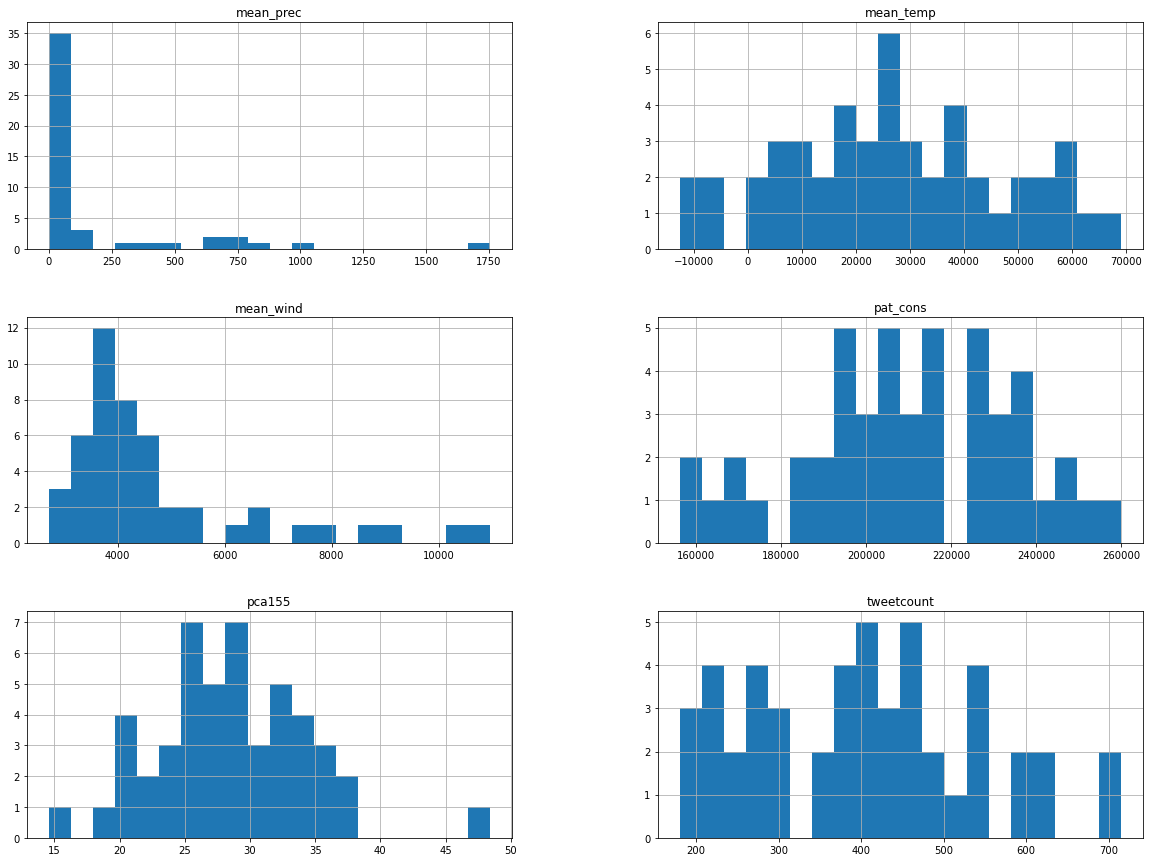

In [6]:
trainA[['date', 'tweetcount', 'mean_prec', 'mean_wind', 'mean_temp', 'pca155', 'pat_cons']].hist(bins=20, figsize=(20,15))
plt.show()

## Analisi delle correlazioni

Vediamo come correlano le features reciprocamente, e se emergono delle problematiche vediamo come affrontarle.

In [7]:
corr = trainA.corr()

In [8]:
#fig1, ax1 = plt.subplots(figsize=(20, 20))
#sns.heatmap(corr, ax=ax1)
corr

tweetcount  mean_prec  mean_wind  mean_temp    pca155    pca272  \
tweetcount    1.000000  -0.250697   0.057894  -0.578179  0.153358  0.153358   
mean_prec    -0.250697   1.000000   0.043047   0.214370  0.062380  0.062380   
mean_wind     0.057894   0.043047   1.000000   0.020559 -0.282751 -0.282751   
mean_temp    -0.578179   0.214370   0.020559   1.000000 -0.147854 -0.147854   
pca155        0.153358   0.062380  -0.282751  -0.147854  1.000000  1.000000   
...                ...        ...        ...        ...       ...       ...   
pcb11098      0.685986  -0.352510   0.074867  -0.745624 -0.053516 -0.053516   
pcb11099      0.685986  -0.352510   0.074867  -0.745624 -0.053516 -0.053516   
pat_cons      0.451237  -0.279909  -0.008651  -0.626877 -0.079015 -0.079015   
tn_cons       0.220656  -0.131602   0.127715  -0.467077 -0.153666 -0.153666   
weekday       0.226565   0.164733  -0.022900   0.000564  0.332861  0.332861   

              pca273    pca276    pca277    pca389  ...  pcb10981  pcb10982  \
tweetcount  0.153358  0.045506  0.045506  0.153358  ...  0.685986  0.529554   
mean_prec   0.062380  0.223315  0.223315  0.062380  ... -0.352510 -0.311226   
mean_wind  -0.282751 -0.236218 -0.236218 -0.282751  ...  0.074867  0.177260   
mean_temp  -0.147854 -0.132675 -0.132675 -0.147854  ... -0.745624 -0.752116   
pca155      1.000000  0.528124  0.528124  1.000000  ... -0.053516 -0.157050   
...              ...       ...       ...       ...  ...       ...       ...   
pcb11098   -0.053516 -0.081336 -0.081336 -0.053516  ...  1.000000  0.933299   
pcb11099   -0.053516 -0.081336 -0.081336 -0.053516  ...  1.000000  0.933299   
pat_cons   -0.079015  0.329336  0.329336 -0.079015  ...  0.534180  0.421628   
tn_cons    -0.153666  0.378717  0.378717 -0.153666  ...  0.221387  0.229324   
weekday     0.332861  0.031127  0.031127  0.332861  ...  0.113817  0.063788   

            pcb10983  pcb10984  pcb11097  pcb11098  pcb11099  pat_cons  \
tweetcount  0.491439  0.491439  0.685986  0.685986  0.685986  0.451237   
mean_prec  -0.298561 -0.298561 -0.352510 -0.352510 -0.352510 -0.279909   
mean_wind   0.194243  0.194243  0.074867  0.074867  0.074867 -0.008651   
mean_temp  -0.741930 -0.741930 -0.745624 -0.745624 -0.745624 -0.626877   
pca155     -0.174560 -0.174560 -0.053516 -0.053516 -0.053516 -0.079015   
...              ...       ...       ...       ...       ...       ...   
pcb11098    0.906291  0.906291  1.000000  1.000000  1.000000  0.534180   
pcb11099    0.906291  0.906291  1.000000  1.000000  1.000000  0.534180   
pat_cons    0.393587  0.393587  0.534180  0.534180  0.534180  1.000000   
tn_cons     0.227363  0.227363  0.221387  0.221387  0.221387  0.845610   
weekday     0.053203  0.053203  0.113817  0.113817  0.113817 -0.466383   

             tn_cons   weekday  
tweetcount  0.220656  0.226565  
mean_prec  -0.131602  0.164733  
mean_wind   0.127715 -0.022900  
mean_temp  -0.467077  0.000564  
pca155     -0.153666  0.332861  
...              ...       ...  
pcb11098    0.221387  0.113817  
pcb11099    0.221387  0.113817  
pat_cons    0.845610 -0.466383  
tn_cons     1.000000 -0.643290  
weekday    -0.643290  1.000000  

[3975 rows x 3975 columns]

![](corrmatrix.png)

Questa ultima figura, poco chiarificatrice sul piano dettagliato ma illuminante su quello complessivo, ci mostra come vi siano forti correlazioni tra righe "adiacenti". Per come sono disposte le celle della suddivisione geografica (in celle quadrate da 200 metri quadri, da sud verso nord, da ovest verso est) comprendiamo effettivamente che queste correlazioni siano dovute molto probabilmente al fatto che i consumi di zone vicine sono molto simili, e per il fatto che consumi sulla stessa linea elettrica tendono a comportarsi in maniera simile. 

Tra l'altro, oltre all'evidente pattern diagonale, che indica la presenza di una forte correlazione tra gruppi di celle direttamente adiacenti, ci sia un più lieve pattern diagonale anche più in basso ed in alto, denotando probabilmente la scansione orizzontale con cui sono organizzate le celle geografiche.

Si tratta quindi di un problema di *multicollinearità*: quando due o più variabili indipendenti sono fra loro correlate, il contributo marginale di una variabile indipendente è dipendente dalle altre, rendendo inaffidabili le stime della regressione e portando a dei coefficienti con varianze grandi. Queste grandi varianze sui parametri minano la predittività del modello.

Di seguito troviamo le "migliori" colonne, ovvero quelle che hanno meno sforamenti del Pearson Correlation Coefficient con un threshold di 0.7 ([Dormann et al., 2013](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1600-0587.2012.07348.x)).

In [9]:
best200feats = (corr > 0.7).sum().sort_values()[:200]
for idx, row in best200feats.iteritems():
    print(idx, row, end=', ')

pca4465 0, pcb4465 0, weekday 1, mean_prec 1, mean_wind 1, mean_temp 1, pcb8512 1, pcb2267 2, tn_cons 2, pcb2972 3, pcb6955 3, pcb2503 4, pcb2504 4, pcb4955 5, pca5072 5, pcb5072 5, pca4955 5, pca4837 5, pca4720 5, pcb4720 5, pcb4837 5, pca4603 5, pcb4603 5, pca2737 6, pcb8120 6, pcb8237 6, pcb8353 6, pcb8469 6, pcb8470 6, pcb8560 6, pcb8587 6, pca1917 7, pca2268 7, pca2151 7, pca2034 7, pca1684 7, pca2385 7, pca7074 8, pcb6956 8, pca6956 8, pca7075 8, pca7192 8, pca7193 8, pcb7193 8, pcb7192 8, pcb7191 8, pcb7075 8, pcb7074 8, pcb7073 8, pcb6957 8, pca7073 8, pca6957 8, pca7191 8, pcb2725 9, pcb2491 9, pcb2139 9, pcb2607 9, pcb2373 9, pcb2854 9, pcb2737 9, pcb2608 9, pcb2258 9, pcb2256 9, pcb2022 9, pca8237 10, pca2373 10, pca2491 10, pca3662 10, pca8587 10, pca1567 10, pca2725 10, pca2022 10, pca8469 10, pca2258 10, pca2139 10, pca2256 10, pca8353 10, pca2607 10, pca8120 10, pca2608 10, pca8470 10, pca3896 11, pca3895 11, pca3545 11, pca3544 11, pca3778 11, pcb2620 11, pca3779 11, pc

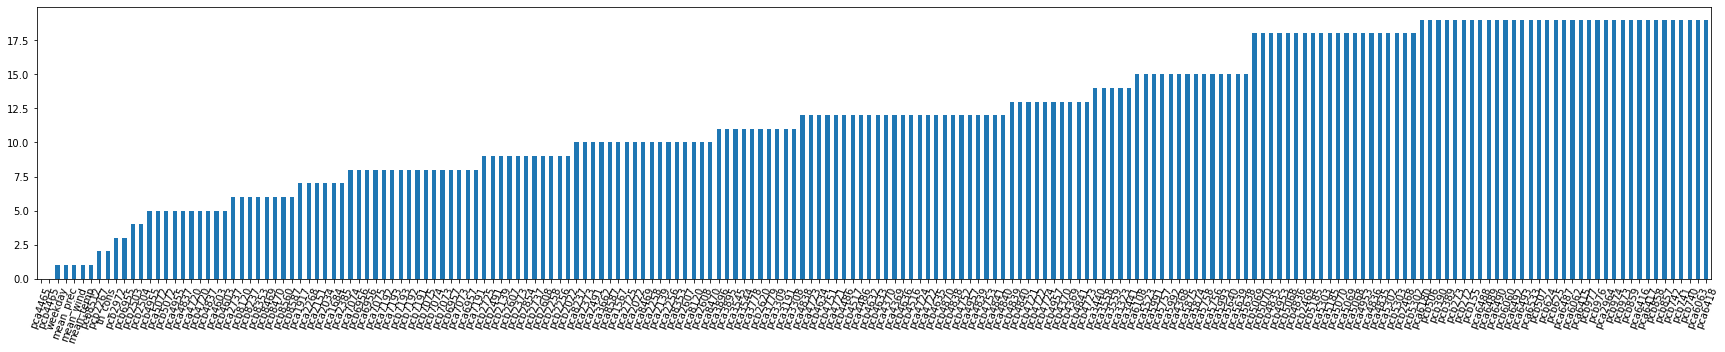

In [10]:
plt.figure(figsize=(30, 5))
best200feats.plot.bar()
plt.xticks(rotation=70)
plt.show()

In [11]:
features_reduced = (corr > 0.7).sum().sort_values().drop('tn_cons').index[:100]
trainA_reduced = trainA[features_reduced]

Abbiamo quindi definito le 200 features che si comportano meglio in termini di correlazioni. Non useremo la Recursive Feature Elimination per [non fare un torto a nessuno](https://statmodeling.stat.columbia.edu/2014/06/02/hate-stepwise-regression/).

Il problema della multicollinearità deriva anche da un'altra proprietà collaterale di questo dataset dovuto alla nostra scelta di usare i singoli dati delle celle geografiche del giorno precedente come feature: dati $p$ e $n$ rispettivamente il numero di features ed il numero di campioni, abbiamo che $p\gg n$! In questi casi sappiamo bene che la regressione lineare *non* generalizza, in quanto l'errore di generalizzazione dato da

$$
\mathbb{E}[|E_{\text{in}} - E_{\text{out}}|] = 2\sigma^2 \frac{p}{n}
$$

esplode. Non sappiamo bene come si comportano gli altri regressori, ma comunque ci aspettiamo che data la dimensione del dataset conviene avere meno features.

Per fortuna esistono altri modelli di regressione che mitigano gli effetti della *multicollinearità* e del cosiddetto *short, fat data problem*. Per fare ciò adottiamo tre approcci di **feature engineering**:

- **Non facciamo alcuna riduzione** di dimensionalità e vediamo se Ridge e LASSO, che sono i *tolerant methods* che ci permettono deputati alla desensibilizzazione dei parametri di regressione alla multicollinearità, effettivamente hanno performance soddisfacenti. Ipotizziamo anche che, data la presenza di tante features molto correlate (quelle dei consumi per cella geografica), il LASSO sia il modello più adatto.
- Usiamo **solo le prime duecento features** appena definite in `features_reduced` per vedere se ci sono degli algoritmi più performanti; [non siamo sicuri di quanto sia legittimo](https://stats.stackexchange.com/questions/286666/what-is-the-best-way-to-go-about-feature-selection-i-am-a-beginner-in-ml) questo sfoltimento di dimensioni, ma proviamo a farlo per vedere se questo genere di analisi determina delle variazioni.
- Facciamo un preprocessing con una **PCA**. Tuttavia dobbiamo fare molta attenzione all'uso di questo metodo di *dimensional reduction*, in quanto presuppone tre ipotesi fondamentali: la *linearità* delle features, il fatto che *la varianza* rispetto a una direzione ne determini l'importanza e l'*ortogonalità* delle Principal Components.

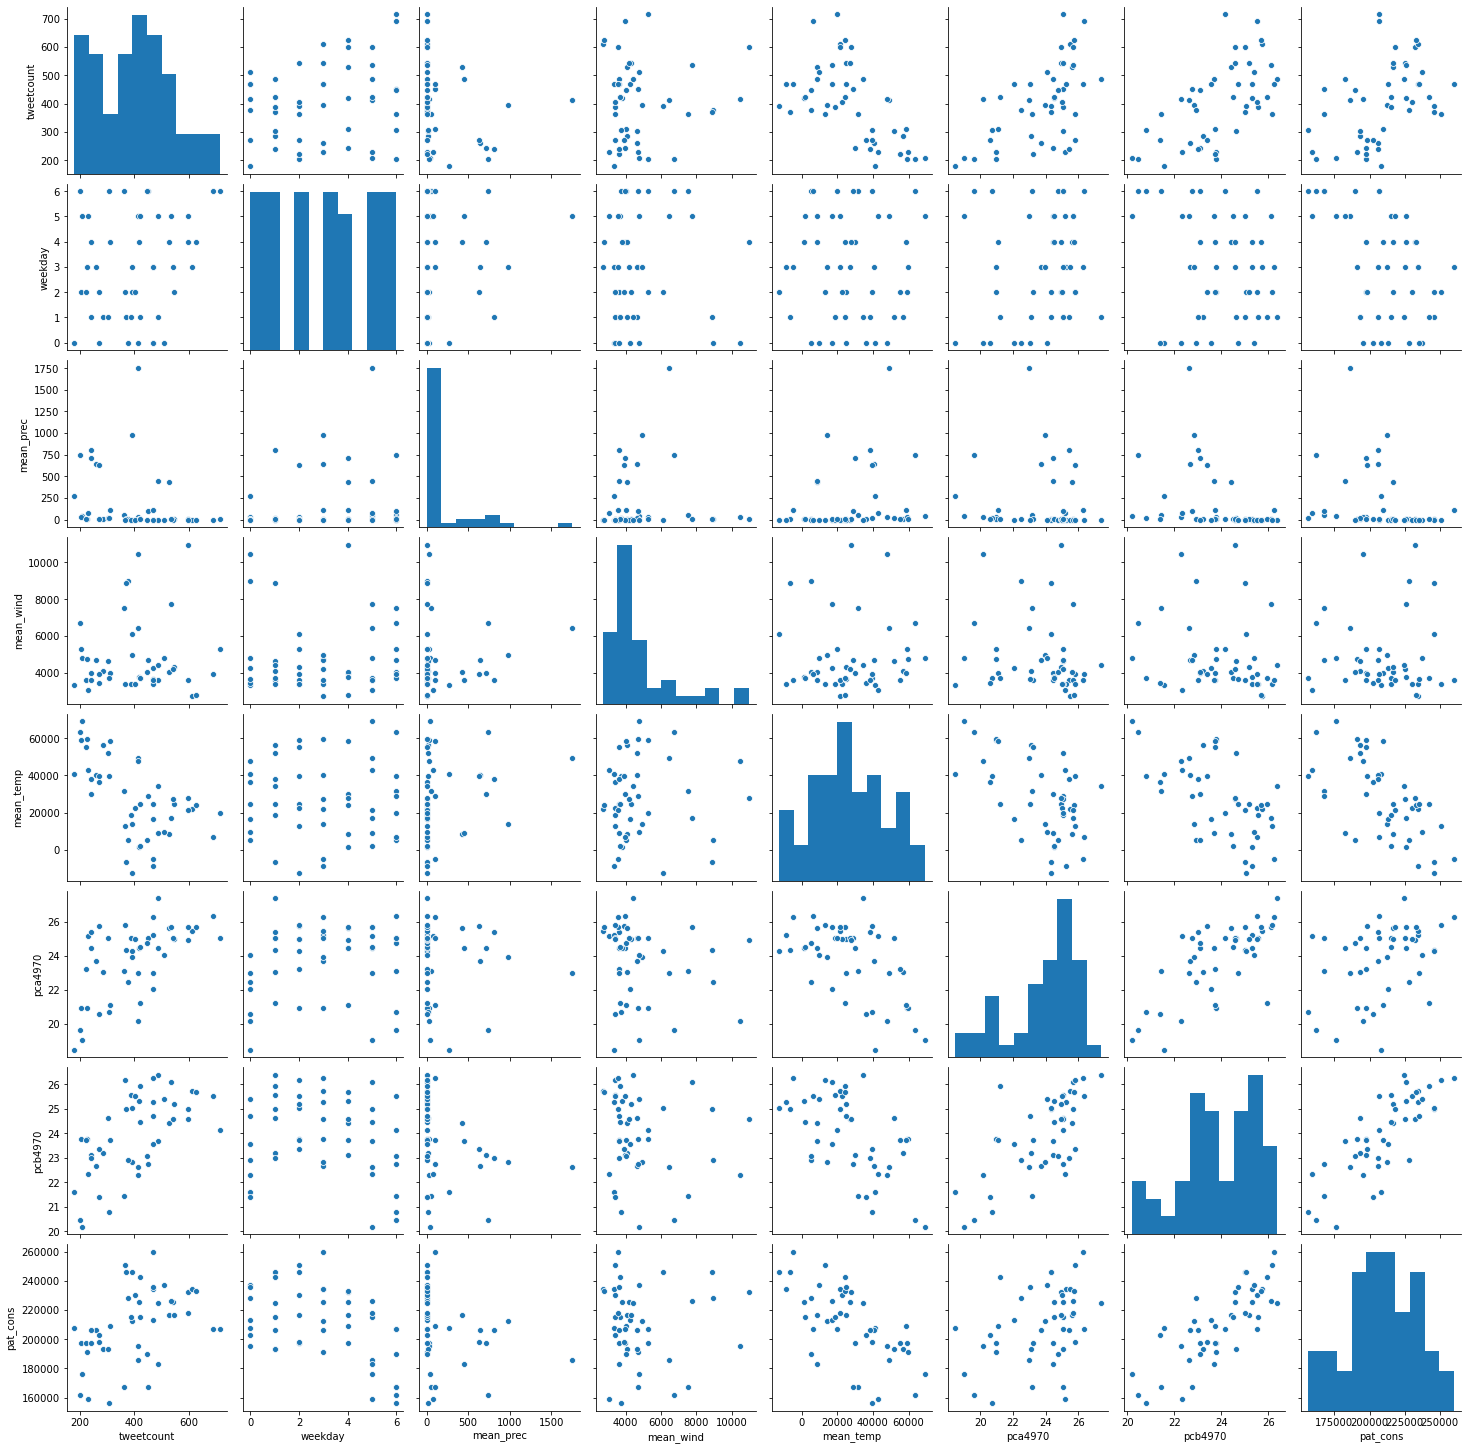

In [12]:
%matplotlib inline
attributes = ['tweetcount', 'weekday', 'mean_prec', 'mean_wind', 'mean_temp', 'pca4970', 'pcb4970', 'pat_cons']
sns.pairplot(trainA[attributes])

Da questa prima immagine vediamo come i giorni della settimana siano poco correlati tra il lunedì ed il giovedì al consumo totale della Provincia. Tuttavia notiamo come tra venerdì e la domenica ci sia una forte anticorrelazione (meno consumi più si va avanti nel fine settimana). Un'altra proprietà interessante è la forte anticorrelazione tra temperatura media e consumi energetici della Provincia: evidentemente con il freddo aumenta l'uso di impianti di riscaldamento o di condizionamento, portando ad un aumento del consumo energetico.

In [13]:
skew_merged = pd.DataFrame(data = trainA.select_dtypes(include = ['int64', 'float64']).skew(), columns = ['Skewness'])
skew_merged_sorted = skew_merged.sort_values(ascending = False, by = 'Skewness')

In [14]:
skew_merged_sorted[(abs(skew_merged_sorted['Skewness'])<2)]

Skewness
pca2622    1.976860
pcb3078    1.951171
pcb3429    1.948627
mean_wind  1.857251
pca4962    1.840623
...             ...
pcb4368   -1.673287
pcb2736   -1.684875
pcb3190   -1.799023
pcb3073   -1.799023
pca1567   -1.959711

[3527 rows x 1 columns]

## Valutazione del modello

Dividiamo le colonne in features numeriche e categoriche: l'unica nostra feature categorica è il giorno della settimana, indicato con un numero intero da 0 a 6. Utilizziamo il OneHot Encoding per suddividerlo in più colonne.

### Caso A: nessuna feature selection

In [15]:
pat_num = pat.drop(['weekday', 'date'], axis=1, errors='ignore')

In [16]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
pat_cat = pat['weekday']
pat_cat_1hot = encoder.fit_transform(pat_cat)

In [17]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.feature_selection import RFE, SelectKBest

class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self;
    def transform(self, X):
        return X[self.attribute_names].values

In [18]:
num_attribs = list(pat_num)
cat_attribs = ['weekday']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizerPipelineFriendly()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

pat_prepared = full_pipeline.fit_transform(trainA)
X1train = pat_prepared.copy()
pat_prepared

array([[-1.43470693, -0.3759886 ,  0.01118772, ...,  0.        ,
         1.        ,  0.        ],
       [-1.47893208,  1.67123251,  1.03912067, ...,  0.        ,
         0.        ,  1.        ],
       [-1.64846183,  0.30584527, -0.74606787, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.13528597, -0.48289264, -0.56025696, ...,  0.        ,
         0.        ,  0.        ],
       [-0.28485298, -0.48361048, -0.71934182, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.48908718, -0.17689324, -0.62096667, ...,  0.        ,
         0.        ,  0.        ]])

Una volta standardizzate le features definiamo i regressori e ne valutiamo le performances confrontando la media delle RMSE ottenute per Cross Validation. Data la particolare sequenzialità del nostro dataset scegliamo di fare una K-folds Cross Validation con $K=5$ e una `TimeSeriesSplit`: in questo tipo di splitting il set di training viene diviso in K-folds e la validazione avviene solo sui folds precedenti. Altrimenti sarebbe come usare anche i dati del futuro per predire i dati passati, che ovviamente non è quello che vogliamo.

In [19]:
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error

In [20]:
linear = LinearRegression(n_jobs=-1)
ridge = Ridge()
kridge = KernelRidge()
lasso = Lasso(tol=0.001, max_iter=10000)
elastic = ElasticNet(tol=0.01, max_iter=1000)
sgd = SGDRegressor()
svr = SVR()
rfr = RandomForestRegressor(n_jobs=-1)
etr = ExtraTreesRegressor()
abr = AdaBoostRegressor()
gbr = GradientBoostingRegressor()
knr = KNeighborsRegressor()
dtr = DecisionTreeRegressor()

In [21]:
time_split = TimeSeriesSplit(n_splits=5)

def cross_validate(model, features, target):
    scores = cross_val_score(model, features, target, scoring='neg_mean_squared_error', cv=time_split, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean(), rmse_scores.std()

models = [linear, ridge, kridge, lasso, elastic, sgd, svr, rfr, etr, abr, gbr, knr, dtr]
training_rmse = []
for model in models:
    mean, std = cross_validate(model, pat_prepared, pat_labels)
    training_rmse.append([mean, std])
training_rmse = np.array(training_rmse)

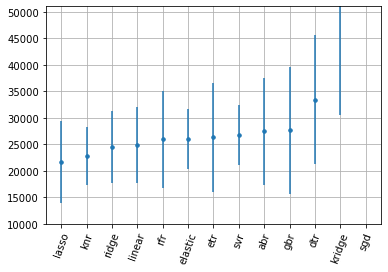

model          error      errorstd
0     lasso          21650  7.806810e+03
1       knr          22767  5.485815e+03
2     ridge          24432  6.832204e+03
3    linear          24828  7.153825e+03
4       rfr          25924  9.133307e+03
5   elastic          25990  5.679015e+03
6       etr          26289  1.026504e+04
7       svr          26721  5.577955e+03
8       abr          27392  1.002884e+04
9       gbr          27624  1.201643e+04
10      dtr          33417  1.209623e+04
11   kridge         457504  4.269136e+05
12      sgd  4655649256371  2.590111e+12

In [22]:
rmse_models = pd.DataFrame({'model': ['linear', 'ridge', 'kridge', 'lasso', 'elastic', 'sgd', 'svr', 'rfr', 'etr', 'abr', 'gbr', 'knr', 'dtr'], 'error': training_rmse[:, 0],'errorstd': training_rmse[:, 1]})
rmse_models['error'] = rmse_models.error.apply(lambda x: int(round(x)))
rmse_models = rmse_models.sort_values('error').reset_index(drop=True)
fig3, ax1 = plt.subplots()
ax1.set_ylim([1e4, 5.1e4])
ax1.grid()
ax1.errorbar(rmse_models['model'], rmse_models['error'], yerr=rmse_models['errorstd'], marker='.', ms=7, fmt=' ')
plt.xticks(rotation=70)
plt.show()

display(rmse_models)

Abbiamo eseguito un training su dodici modelli di regressione, e abbiamo trovato che i modelli con RMSE più basso e quindi più promettenti sono:

- Lasso Regression
- K Neighboring Regressor
- Ridge Regression

Adesso cerchiamo di ottimizzare gli iperparametri per trovare il modello migliore.

#### Ottimizzazione degli iperparametri

In [23]:
def hyperp_optim(model, params, features, target):
    global best_params, best_score, best_estimator
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv=time_split, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(features, target)
    best_params = grid_search.best_params_
    best_score = np.sqrt(-grid_search.best_score_)
    best_estimator = grid_search.best_estimator_
    return best_params, best_score, best_estimator

In [24]:
lasso_params = [
    {'alpha': [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1., 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.],}
]

knr_params = [
    {'n_neighbors': [2, 3, 4, 5, 6],
     'weights': ['uniform', 'distance'],
     'algorithm': ['ball_tree', 'kd_tree'],
     'leaf_size': [1,2,3,4,5,6,7,8,9,10],
    },
    {'n_neighbors': [2, 3, 4, 5, 6],
     'weights': ['uniform', 'distance'],
     'algorithm': ['brute'],
    },
]

ridge_params = [
    {'alpha': [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1., 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.],
     'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],},
]

for modelname, model, params in zip(['lasso', 'knr', 'ridge'], [lasso, knr, ridge], [lasso_params, knr_params, ridge_params]):
    best_params, best_score, best_estimator = hyperp_optim(model, params, pat_prepared, pat_labels)
    print('{}\'s best parameters are {}\n{}\'s best score is {}\n'.format(modelname, best_params, modelname, best_score))
    exec(modelname+'_best_estimator = best_estimator')

lasso's best parameters are {'alpha': 1.8}
lasso's best score is 21270.22725192888

knr's best parameters are {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 3, 'weights': 'uniform'}
knr's best score is 22330.964268090273

ridge's best parameters are {'alpha': 2.0, 'solver': 'sag'}
ridge's best score is 25322.006072401833



In [25]:
final_model_1 = lasso_best_estimator

X_test = testA.drop(['pat_cons', 'tn_cons'], axis=1)
y_test = testA['pat_cons'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model_1.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [26]:
final_rmse

26410.551784663498

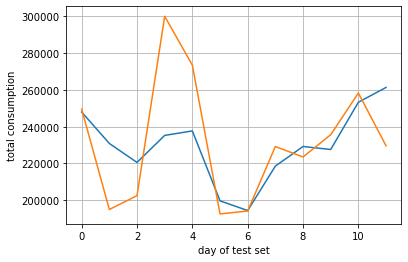

In [27]:
plt.figure()
plt.grid()
plt.plot(y_test.values)
plt.plot(final_predictions)
plt.xlabel('day of test set')
plt.ylabel('total consumption')
plt.show()

### Caso B: Feature Selection Manuale

Proviamo a ridurre la dimensionalità manualmente e vedere che risultati porta questo tipo di manipolazione.

In [28]:
trainA_reduced.head()

pca4465  pcb4465  weekday   mean_prec  mean_wind  mean_temp  pcb8512  \
1      0.0      0.0        5   37.168750    4775.95   69105.55      0.0   
2      0.0      0.0        6  744.205702    6716.35   63509.25      0.0   
3      0.0      0.0        0  272.649781    3346.50   40925.65      0.0   
4      0.0      0.0        1   11.035965    4068.45   56657.10      0.0   
5      0.0      0.0        2   30.890592    5293.40   58988.45      0.0   

     pcb2267    pcb2972   pcb6955  ...    pca4838    pca4723    pcb4634  \
1  22.816270  57.167677  0.110597  ...  17.960509  15.363176  14.650544   
2  23.204794  59.121347  0.110670  ...  17.454698  15.568390  15.787271   
3  23.522653  58.444864  0.110988  ...  17.404005  15.054088  16.019903   
4  25.831656  65.466789  0.111326  ...  18.539238  16.292972  11.108190   
5  26.514560  67.149886  0.113732  ...  16.260238  13.265434  12.281926   

     pcb4751    pca4721    pcb4486    pcb4517    pca4486    pcb4632    pcb4633  
1  14.650544  15.363176  17.946391  14.650544  17.960509  14.650544  14.650544  
2  15.787271  15.568390  19.145747  15.787271  17.454698  15.787271  15.787271  
3  16.019903  15.054088  19.028744  16.019903  17.404005  16.019903  16.019903  
4  11.108190  16.292972  19.578808  11.108190  18.539238  11.108190  11.108190  
5  12.281926  13.265434  19.530615  12.281926  16.260238  12.281926  12.281926  

[5 rows x 100 columns]

In [29]:
pat_num = trainA_reduced.drop(['weekday', 'date'], axis=1, errors='ignore')

In [30]:
num_attribs = list(pat_num)
cat_attribs = ['weekday']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizerPipelineFriendly()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

pat_prepared = full_pipeline.fit_transform(trainA_reduced)
X2train = pat_prepared.copy()
pat_prepared

array([[ 0.        ,  0.        , -0.3759886 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.67123251, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.30584527, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , -0.48289264, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.48361048, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.17689324, ...,  0.        ,
         0.        ,  0.        ]])

In [31]:
linear = LinearRegression(n_jobs=-1)
ridge = Ridge()
kridge = KernelRidge()
lasso = Lasso(tol=0.001, max_iter=10000)
elastic = ElasticNet(tol=0.01, max_iter=1000)
sgd = SGDRegressor()
svr = SVR()
rfr = RandomForestRegressor(n_jobs=-1)
etr = ExtraTreesRegressor()
abr = AdaBoostRegressor()
gbr = GradientBoostingRegressor()
knr = KNeighborsRegressor()
dtr = DecisionTreeRegressor()

In [32]:
time_split = TimeSeriesSplit(n_splits=5)

def cross_validate(model, features, target):
    scores = cross_val_score(model, features, target, scoring='neg_mean_squared_error', cv=time_split, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean(), rmse_scores.std()

models = [linear, ridge, kridge, lasso, elastic, sgd, svr, rfr, etr, abr, gbr, knr, dtr]
training_rmse = []
for model in models:
    mean, std = cross_validate(model, pat_prepared, pat_labels)
    training_rmse.append([mean, std])
training_rmse = np.array(training_rmse)

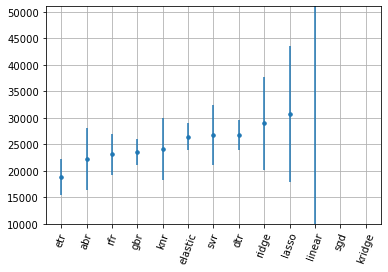

model   error       errorstd
0       etr   18748    3388.513601
1       abr   22266    5875.619699
2       rfr   23086    3912.280860
3       gbr   23530    2467.143988
4       knr   24100    5818.381722
5   elastic   26394    2549.199535
6       svr   26721    5578.321793
7       dtr   26784    2836.875874
8     ridge   28974    8758.957694
9     lasso   30698   12853.526062
10   linear   89622  126520.373220
11      sgd  158848   73956.167479
12   kridge  309811  196162.674001

In [33]:
rmse_models = pd.DataFrame({'model': ['linear', 'ridge', 'kridge', 'lasso', 'elastic', 'sgd', 'svr', 'rfr', 'etr', 'abr', 'gbr', 'knr', 'dtr'], 'error': training_rmse[:, 0],'errorstd': training_rmse[:, 1]})
rmse_models['error'] = rmse_models.error.apply(lambda x: int(round(x)))
rmse_models = rmse_models.sort_values('error').reset_index(drop=True)
fig3, ax1 = plt.subplots()
ax1.set_ylim([1e4, 5.1e4])
ax1.grid()
ax1.errorbar(rmse_models['model'], rmse_models['error'], yerr=rmse_models['errorstd'], marker='.', ms=7, fmt=' ')
plt.xticks(rotation=70)
plt.show()

display(rmse_models)

Abbiamo eseguito un training su dodici modelli di regressione, e abbiamo trovato che i modelli con RMSE più basso e quindi più promettenti sono:

- Extra Tree Regressor
- AdaBoostRegressor
- Random Tree Regressor

Vediamo che, poiché abbiamo già sfoltito le dimensioni, evidentemente ridge e LASSO non hanno più funzioni da regolarizzare e quindi hanno performance mediocri.

Adesso cerchiamo di ottimizzare gli iperparametri per trovare il modello migliore.

#### Ottimizzazione degli iperparametri

In [34]:
def hyperp_optim(model, params, features, target):
    global best_params, best_score, best_estimator
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv=time_split, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(features, target)
    best_params = grid_search.best_params_
    best_score = np.sqrt(-grid_search.best_score_)
    best_estimator = grid_search.best_estimator_
    return best_params, best_score, best_estimator

In [35]:
etr_params = [
    {'criterion': ['mse', 'mae', 'friedman_mse'],
    }
]

abr_params = [
    {'n_estimators': [50, 100, 150, 200],
     'loss': ['linear', 'square', 'exponential'],
    },
]

rfr_params = [
    {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
     'max_features': ['auto', 'sqrt', 'log2'],
    },
    {'bootstrap': [False],
     'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
     'max_features': ['auto', 'sqrt', 'log2'],
    },
]

for modelname, model, params in zip(['etr', 'abr', 'rfr'], [etr, abr, rfr], [etr_params, abr_params, rfr_params]):
    best_params, best_score, best_estimator = hyperp_optim(model, params, pat_prepared, pat_labels)
    print('{}\'s best parameters are {}\n{}\'s best score is {}\n'.format(modelname, best_params, modelname, best_score))
    exec(modelname+'_best_estimator = best_estimator')

etr's best parameters are {'criterion': 'mae'}
etr's best score is 18549.712141431653

abr's best parameters are {'loss': 'square', 'n_estimators': 100}
abr's best score is 22104.005766001705

rfr's best parameters are {'max_features': 'auto', 'n_estimators': 20}
rfr's best score is 22096.637737404788



In [36]:
final_model_2 = etr_best_estimator

X_test = testA.drop(['pat_cons', 'tn_cons'], axis=1)
y_test = testA['pat_cons'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model_2.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [37]:
final_rmse

21148.291797629125

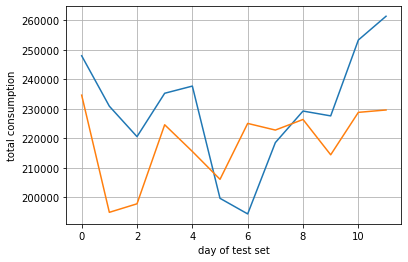

In [38]:
plt.figure()
plt.grid()
plt.plot(y_test.values)
plt.plot(final_predictions)
plt.xlabel('day of test set')
plt.ylabel('total consumption')
plt.show()

Otteniamo un RMSE lievemente minore rispetto al caso in cui consideriamo tutte le features. Tuttavia, come già detto, non sappiamo se questo sfoltimento arbitrario sia giustificabile teoricamente o meno, in ultima istanza quindi se questo risultato apparentemente migliore non porti con sè delle fondamentali distorsioni nelle assunzioni iniziali.

### Caso C: Dimensional Reduction con PCA

In [39]:
from sklearn.decomposition import PCA
trainA.head()

date  tweetcount   mean_prec  mean_wind  mean_temp     pca155  \
1 2013-11-02       209.0   37.168750    4775.95   69105.55  14.585304   
2 2013-11-03       203.0  744.205702    6716.35   63509.25  26.031270   
3 2013-11-04       180.0  272.649781    3346.50   40925.65  20.691523   
4 2013-11-05       285.0   11.035965    4068.45   56657.10  36.039039   
5 2013-11-06       206.0   30.890592    5293.40   58988.45  21.844423   

      pca272     pca273      pca276      pca277  ...  pcb10981  pcb10982  \
1  14.585304  14.585304   56.631025   56.631025  ...  3.145741  8.442657   
2  26.031270  26.031270   74.861560   74.861560  ...  3.292060  8.725471   
3  20.691523  20.691523   64.536655   64.536655  ...  3.184689  8.594513   
4  36.039039  36.039039  142.145393  142.145393  ...  3.232690  8.758881   
5  21.844423  21.844423  124.130793  124.130793  ...  3.245322  8.937887   

   pcb10983  pcb10984  pcb11097  pcb11098  pcb11099       pat_cons  \
1  5.296916  5.296916  3.145741  3.145741  3.145741  176140.243667   
2  5.433411  5.433411  3.292060  3.292060  3.292060  161647.247910   
3  5.409823  5.409823  3.184689  3.184689  3.184689  207924.113704   
4  5.526191  5.526191  3.232690  3.232690  3.232690  193472.206341   
5  5.692565  5.692565  3.245322  3.245322  3.245322  197676.123419   

        tn_cons  weekday  
1  13774.639250        5  
2  13232.001240        6  
3  16673.634263        0  
4  16202.398468        1  
5  15918.825752        2  

[5 rows x 3976 columns]

In [40]:
pat_num = trainA.drop(['weekday', 'date'], axis=1, errors='ignore')

In [41]:
num_attribs = list(pat_num)
cat_attribs = ['weekday']

pca = PCA(whiten=True)

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
    ('dim_red', pca),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizerPipelineFriendly()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

pat_prepared = full_pipeline.fit_transform(trainA)
X3train = pat_prepared.copy()
pat_prepared

array([[ 1.85868439,  0.76682942, -0.28330642, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.31158749,  0.43007415, -0.38625533, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.97697539,  0.62925598, -0.15345926, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.08237808, -0.15284634, -1.59821923, ...,  0.        ,
         0.        ,  0.        ],
       [-1.22909525, -0.12596292, -1.40982995, ...,  0.        ,
         0.        ,  0.        ],
       [-1.52233721,  0.06853151, -1.37200161, ...,  0.        ,
         0.        ,  0.        ]])

Nell'eseguire la PCA scegliamo di attivare il **whitening**: è un preprocessor che [si usa su dati molto ridondanti](http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/). Infatti le nostre celle geografiche sono adiacenti l'una all'altra, e quindi ci aspettiamo che i consumi elettrici di una siano strettamente collegati ai consumi elettrici dell'altra. Il whitening fa sì che il nostro algoritmo di apprendimento veda un input con features meno correlate e con la stessa varianza.

Vediamo di seguito i primi coefficienti di proiezione della PCA e le varianze delle direzioni prese in considerazione.

In [42]:
display(pd.DataFrame(pca.components_).head(),  pd.DataFrame(pca.explained_variance_).values[:,0])

0         1         2         3         4         5         6     \
0 -0.018417  0.006150  0.005175  0.019255 -0.011346 -0.011346 -0.011346   
1  0.014743 -0.015284  0.005364 -0.016423 -0.015064 -0.015064 -0.015064   
2 -0.010969  0.005749  0.006322 -0.016327 -0.004469 -0.004469 -0.004469   
3 -0.011429 -0.012399  0.000982  0.012915 -0.025932 -0.025932 -0.025932   
4  0.012635 -0.022341  0.019667 -0.000661 -0.030172 -0.030172 -0.030172   

       7         8         9     ...      3964      3965      3966      3967  \
0 -0.017658 -0.017658 -0.011346  ... -0.018196 -0.018196 -0.014401 -0.013453   
1 -0.028506 -0.028506 -0.015064  ...  0.023050  0.023050  0.024087  0.023920   
2  0.004681  0.004681 -0.004469  ...  0.003313  0.003313  0.016123  0.018340   
3 -0.000052 -0.000052 -0.025932  ... -0.001247 -0.001247 -0.000006  0.000232   
4  0.000975  0.000975 -0.030172  ... -0.006222 -0.006222 -0.002763 -0.002056   

       3968      3969      3970      3971      3972      3973  
0 -0.013453 -0.018196 -0.018196 -0.018196 -0.019875 -0.012495  
1  0.023920  0.023050  0.023050  0.023050  0.006212 -0.002454  
2  0.018340  0.003313  0.003313  0.003313 -0.001354  0.011532  
3  0.000232 -0.001247 -0.001247 -0.001247  0.012902  0.010446  
4 -0.002056 -0.006222 -0.006222 -0.006222  0.023765  0.042510  

[5 rows x 3974 columns]

array([1.22366565e+03, 7.13350550e+02, 4.54840723e+02, 2.94637135e+02,
       1.33855051e+02, 1.20118796e+02, 1.08949090e+02, 9.05924234e+01,
       8.87560620e+01, 7.24293463e+01, 6.99896439e+01, 6.30410281e+01,
       5.52430418e+01, 4.83483094e+01, 4.73379908e+01, 3.78445312e+01,
       3.70467613e+01, 3.70068724e+01, 2.85566416e+01, 2.70839377e+01,
       2.58126724e+01, 2.41818232e+01, 2.28254885e+01, 2.03145036e+01,
       1.87272948e+01, 1.76322156e+01, 1.65195399e+01, 1.50511844e+01,
       1.41153806e+01, 1.31021281e+01, 1.22550727e+01, 1.17853466e+01,
       1.13500070e+01, 9.73224225e+00, 8.55462389e+00, 7.71307213e+00,
       7.00555951e+00, 6.42576608e+00, 6.34603821e+00, 5.95923943e+00,
       5.67604990e+00, 4.80071017e+00, 4.68241357e+00, 4.31849045e+00,
       3.55052969e+00, 3.13668117e+00, 2.24298011e+00, 6.54045999e-28])

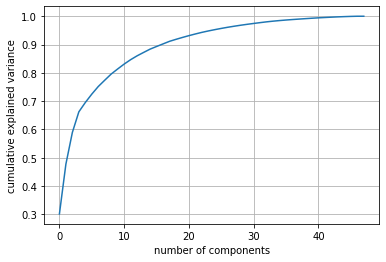

In [43]:
plt.figure()
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [44]:
feat_redfact = 1-47/3975
print('Fattore di riduzione delle features:' , feat_redfact)

Fattore di riduzione delle features: 0.9881761006289308


La figura precedente descrive quanto in termini percentuali le prime $N$ componenti descrivono rispetto alla varianza totale. Da questa curva si deduce che il 75% della varianza è già descritta circa dalle prime sette componenti, mentre si raggiunge quasi il 100% già con sole quaranta componenti. Questo significa che, se intelligentemente proiettate, **con la PCA e il whitening riusciamo a ridurre del 98.82% la quantità di features**. È un risultato impressionante, che effettivamente qualifica la presenza di parametri fortemente correlati all'interno del dataset.

In [45]:
linear = LinearRegression(n_jobs=-1)
ridge = Ridge()
kridge = KernelRidge()
lasso = Lasso(tol=0.001, max_iter=10000)
elastic = ElasticNet(tol=0.01, max_iter=1000)
sgd = SGDRegressor()
svr = SVR()
rfr = RandomForestRegressor(n_jobs=-1)
etr = ExtraTreesRegressor()
abr = AdaBoostRegressor()
gbr = GradientBoostingRegressor()
knr = KNeighborsRegressor()
dtr = DecisionTreeRegressor()

In [46]:
time_split = TimeSeriesSplit(n_splits=5)

def cross_validate(model, features, target):
    scores = cross_val_score(model, features, target, scoring='neg_mean_squared_error', cv=time_split, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean(), rmse_scores.std()

models = [linear, ridge, kridge, lasso, elastic, sgd, svr, rfr, etr, abr, gbr, knr, dtr]
training_rmse = []
for model in models:
    mean, std = cross_validate(model, pat_prepared, pat_labels)
    training_rmse.append([mean, std])
training_rmse = np.array(training_rmse)

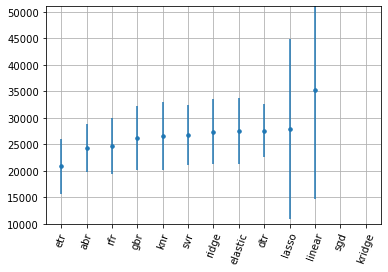

model   error      errorstd
0       etr   20830   5169.981830
1       abr   24316   4506.523383
2       rfr   24618   5291.462782
3       gbr   26223   6018.923267
4       knr   26537   6384.206044
5       svr   26721   5578.366915
6     ridge   27361   6178.422951
7   elastic   27450   6211.918934
8       dtr   27531   4987.783062
9     lasso   27887  16919.244423
10   linear   35275  20596.192549
11      sgd  146224   8169.029277
12   kridge  201650  12500.755078

In [47]:
rmse_models = pd.DataFrame({'model': ['linear', 'ridge', 'kridge', 'lasso', 'elastic', 'sgd', 'svr', 'rfr', 'etr', 'abr', 'gbr', 'knr', 'dtr'], 'error': training_rmse[:, 0],'errorstd': training_rmse[:, 1]})
rmse_models['error'] = rmse_models.error.apply(lambda x: int(round(x)))
rmse_models = rmse_models.sort_values('error').reset_index(drop=True)
fig3, ax1 = plt.subplots()
ax1.set_ylim([1e4, 5.1e4])
ax1.grid()
ax1.errorbar(rmse_models['model'], rmse_models['error'], yerr=rmse_models['errorstd'], marker='.', ms=7, fmt=' ')
plt.xticks(rotation=70)
plt.show()

display(rmse_models)

Abbiamo eseguito un training su dodici modelli di regressione, e abbiamo trovato che i modelli con RMSE più basso e quindi più promettenti sono:

- ElasticNet Regressor
- Extra Tree Regressor
- K Nearest Neighbor Regressor

Adesso cerchiamo di ottimizzare gli iperparametri per trovare il modello migliore.

#### Ottimizzazione degli iperparametri

In [48]:
elastic_params = [
    {'alpha': [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1., 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.],
     'l1_ratio': [.1, .2, .3, .4, .5, .6, .7, .8, .9]
    }
]

etr_params = [
    {'criterion': ['mse', 'mae', 'friedman_mse'],
    }
]

knr_params = [
    {'n_neighbors': [2, 3, 4, 5, 6],
     'weights': ['uniform', 'distance'],
     'algorithm': ['ball_tree', 'kd_tree'],
     'leaf_size': [1,2,3,4,5,6,7,8,9,10],
    },
    {'n_neighbors': [2, 3, 4, 5, 6],
     'weights': ['uniform', 'distance'],
     'algorithm': ['brute'],
    },
]

for modelname, model, params in zip(['elastic', 'etr', 'knr'], [elastic, etr, knr], [elastic_params, etr_params, knr_params]):
    best_params, best_score, best_estimator = hyperp_optim(model, params, pat_prepared, pat_labels)
    print('{}\'s best parameters are {}\n{}\'s best score is {}\n'.format(modelname, best_params, modelname, best_score))
    exec(modelname+'_best_estimator = best_estimator')

elastic's best parameters are {'alpha': 0.1, 'l1_ratio': 0.9}
elastic's best score is 24001.61367353492

etr's best parameters are {'criterion': 'mae'}
etr's best score is 21162.470072672008

knr's best parameters are {'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'distance'}
knr's best score is 27294.3902207748



In [49]:
final_model_3 = etr_best_estimator

X_test = testA
y_test = testA['pat_cons'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model_3.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [50]:
final_rmse

21739.195701563636

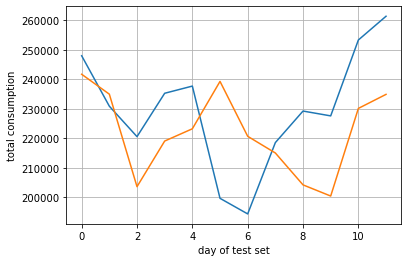

In [51]:
plt.figure()
plt.grid()
plt.plot(y_test.values)
plt.plot(final_predictions)
plt.xlabel('day of test set')
plt.ylabel('total consumption')
plt.show()

## Learning Curves

Utilizziamo questa [funzione basata su SKLearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py) per valutare il tradeoff Bias-Varianza dei tre modelli.

In [52]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from '/usr/lib/python3.8/site-packages/matplotlib/pyplot.py'>

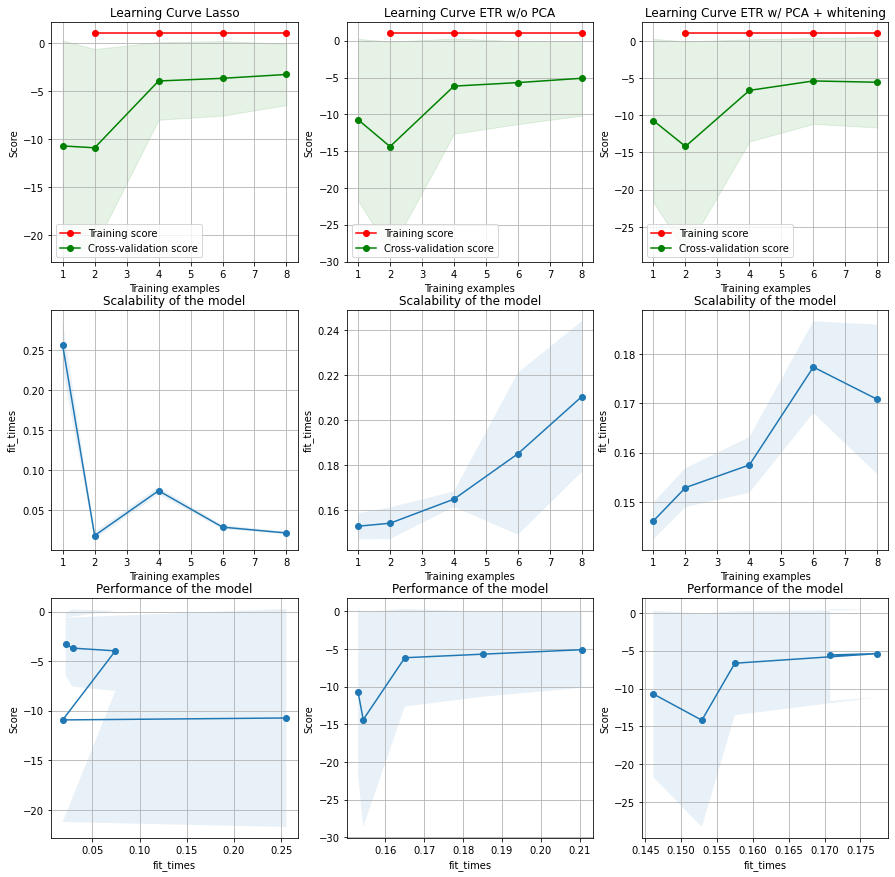

In [53]:
fig_lc0, axes_lc0 = plt.subplots(3, 3, figsize=(15, 15))

title = 'Learning Curve Lasso'
X = X1train
y = pat_labels
plot_learning_curve(final_model_1, title, X, y, axes=axes_lc0[:,0], cv=time_split, n_jobs=-1)

title = 'Learning Curve ETR w/o PCA'
X = X2train
y = pat_labels
plot_learning_curve(final_model_2, title, X, y, axes=axes_lc0[:,1], cv=time_split, n_jobs=-1)

title = 'Learning Curve ETR w/ PCA + whitening'
X = X3train
y = pat_labels
plot_learning_curve(final_model_3, title, X, y, axes=axes_lc0[:,2], cv=time_split, n_jobs=-1)

Abbiamo plottato le Learning Curves per 5 folds. Bisogna tenere conto che la grande varianza dello score è dovuta anche alla scelta dello splitting per serie temporali, che effettivamente induce una "tendenza" a seconda dei folding successivi.

Ovviamente, poiché non si tratta di un fit ma di un algoritmo di apprendimento, qui non stiamo confrontando le performances dei nostri modelli ma stiamo illustrando le diverse possibilità per ridurre le features. L'unica conclusione che possiamo tirare qui è che vista la struttura dei nostri dataset, sia la LASSO che la PCA possono fare al caso nostro.

# Regressione: Comune di Trento

Qui utilizziamo soltanto la PCA + whitening.

In [55]:
dfB.head()

date  tweetcount  mean_prec  mean_wind  mean_temp    pca4030  \
1 2013-11-02        71.0   0.654167     364.45    2712.90  41.694399   
2 2013-11-03        71.0  17.213399     558.80    2839.00  43.153952   
3 2013-11-04        76.0  10.591667     229.90    1831.75  39.017625   
4 2013-11-05        87.0   0.020833     312.10    2361.95  62.411181   
5 2013-11-06        94.0   0.000000     477.00    2234.55  55.845964   

     pca4031    pca4145    pca4146    pca4147  ...    pcb6021    pcb6136  \
1  41.694399  50.965561  50.965561  41.694399  ...  25.849352  41.125464   
2  43.153952  51.328986  51.328986  43.153952  ...  26.865463  44.336298   
3  39.017625  49.181725  49.181725  39.017625  ...  27.587283  43.433902   
4  62.411181  73.972333  73.972333  62.411181  ...  29.382316  48.935981   
5  55.845964  68.179720  68.179720  55.845964  ...  29.489930  48.555404   

     pcb6137    pcb6138    pcb6253    pcb6254    pcb6255    pcb6256  \
1  43.691654  25.849352  39.529915  42.096105  42.096105  42.096105   
2  45.447355  26.865463  41.888740  42.999797  42.999797  42.999797   
3  45.688104  27.587283  39.014999  41.269201  41.269201  41.269201   
4  49.647503  29.382316  46.038680  46.750201  46.750201  46.750201   
5  50.885406  29.489930  45.132613  47.462615  47.462615  47.462615   

        tn_cons  weekday  
1  13774.639250        5  
2  13232.001240        6  
3  16673.634263        0  
4  16202.398468        1  
5  15918.825752        2  

[5 rows x 301 columns]

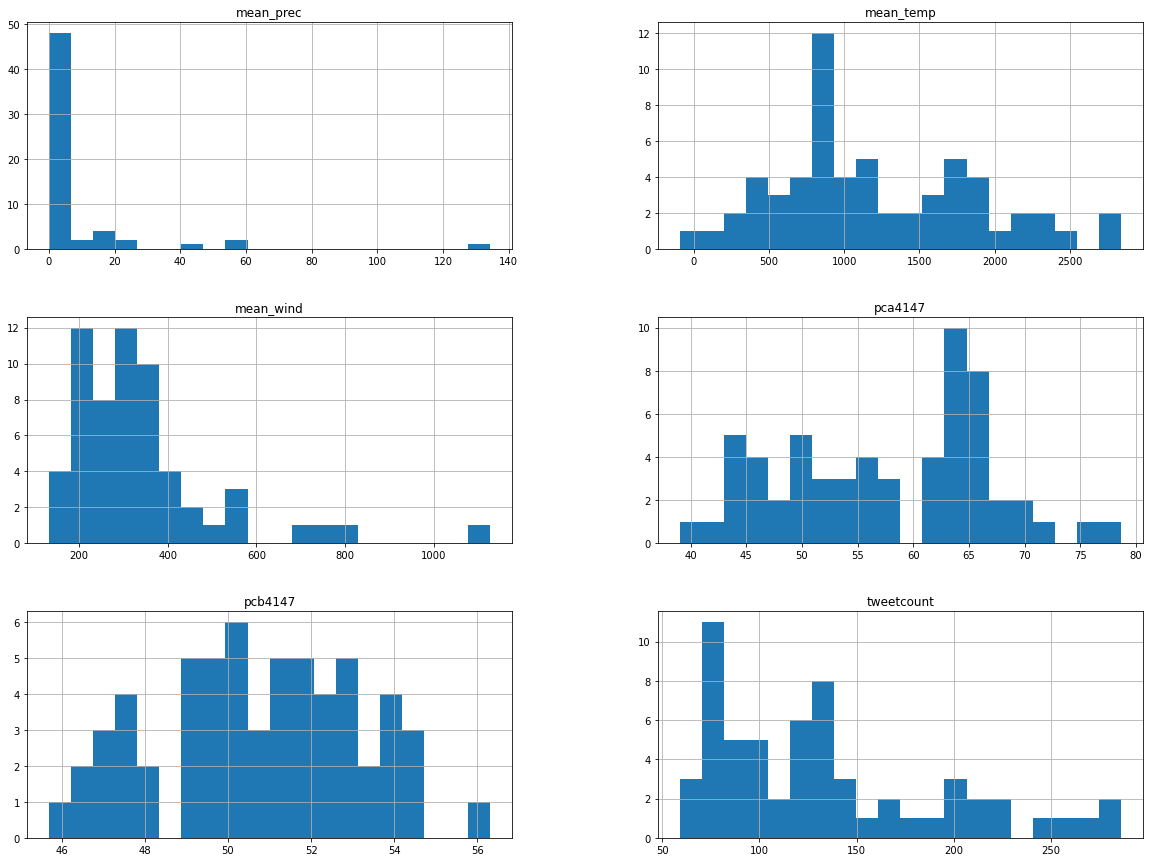

In [56]:
dfB[['date', 'tweetcount', 'mean_prec', 'mean_wind', 'mean_temp', 'pca4147', 'pcb4147']].hist(bins=20, figsize=(20,15))
plt.show()

In [57]:
trainB, testB = train_test_split(dfB, test_size=0.2, shuffle=False)

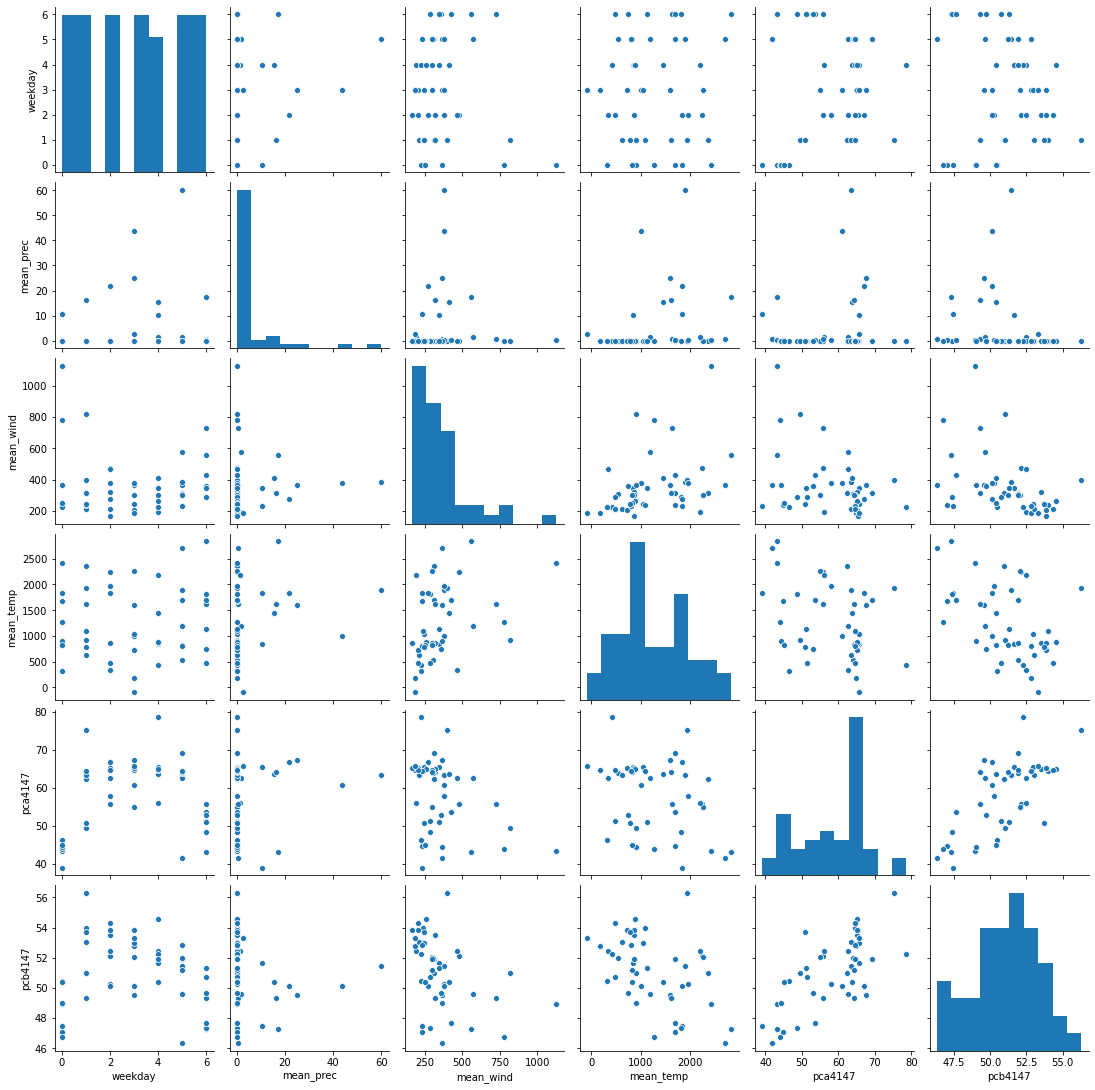

In [58]:
%matplotlib inline
attributes = ['weekday', 'mean_prec', 'mean_wind', 'mean_temp', 'pca4147', 'pcb4147']
sns.pairplot(trainB[attributes])

In [59]:
correlation = trainB.corr()
corr_values = correlation['tn_cons'].sort_values(ascending=False)

In [60]:
skew_merged = pd.DataFrame(data = trainB.select_dtypes(include = ['int64', 'float64']).skew(), columns = ['Skewness'])
skew_merged_sorted = skew_merged.sort_values(ascending = False, by = 'Skewness')

In [61]:
skew_merged_sorted[(abs(skew_merged_sorted['Skewness'])<2)]

Skewness
pca5081  1.840623
pca4492  1.840623
pca4963  1.840623
pca4962  1.840623
pca4845  1.840623
...           ...
pca4848 -1.025946
pca5551 -1.081532
pca5552 -1.307365
pca5553 -1.307365
pca5669 -1.307365

[298 rows x 1 columns]

In [62]:
tn = trainB.drop(['tn_cons'], axis=1)
tn_labels = trainB['tn_cons'].copy()

In [63]:
tn_num = tn.drop(['weekday', 'date'], axis=1)

In [64]:
num_attribs = list(tn_num)
cat_attribs = ['weekday']

pca = PCA(whiten=True)

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
    ('dim_red', pca),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizerPipelineFriendly()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

tn_prepared = full_pipeline.fit_transform(tn)
tn_prepared

array([[ 2.14296906, -0.89140277, -0.29488056, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.65719405, -0.75784954, -0.11259099, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.99881844, -0.65191896, -0.87725785, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.41233194, -0.06658816, -1.93746309, ...,  0.        ,
         0.        ,  0.        ],
       [-0.96652721, -0.05293623, -0.87303088, ...,  0.        ,
         0.        ,  0.        ],
       [-0.93394772,  0.05691395, -0.4510492 , ...,  0.        ,
         0.        ,  0.        ]])

## Valutazione del modello

In [65]:
linear = LinearRegression(n_jobs=-1)
ridge = Ridge()
kridge = KernelRidge()
lasso = Lasso(tol=0.001, max_iter=10000)
#lasso = Lasso()
elastic = ElasticNet(tol=0.01, max_iter=1000)
#elastic = ElasticNet()
sgd = SGDRegressor()
svr = SVR()
rfr = RandomForestRegressor(n_jobs=-1)
etr = ExtraTreesRegressor(n_jobs=-1)
abr = AdaBoostRegressor()
gbr = GradientBoostingRegressor()
knr = KNeighborsRegressor()
dtr = DecisionTreeRegressor()

In [66]:
time_split = TimeSeriesSplit(n_splits=5)

#def cross_validate(model, features, target):
#    scores = cross_val_score(model, features, target, scoring='neg_mean_squared_error', cv=time_split, n_jobs=-1)
#    rmse_scores = np.sqrt(-scores)
#    return rmse_scores.mean()

models = [linear, ridge, kridge, lasso, elastic, sgd, svr, rfr, etr, abr, gbr, knr, dtr]
training_rmse = []
for model in models:
    mean, std = cross_validate(model, pat_prepared, pat_labels)
    training_rmse.append([mean, std])
training_rmse = np.array(training_rmse)

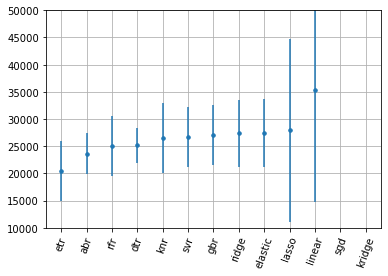

model   error      errorstd
0       etr   20458   5486.468175
1       abr   23642   3702.312150
2       rfr   25061   5470.105635
3       dtr   25168   3173.918876
4       knr   26537   6384.206044
5       svr   26721   5578.366915
6       gbr   27020   5536.483662
7     ridge   27361   6178.422951
8   elastic   27450   6211.918934
9     lasso   27887  16919.244423
10   linear   35275  20596.192549
11      sgd  146225   8167.950549
12   kridge  201650  12500.755078

In [67]:
rmse_models = pd.DataFrame({'model': ['linear', 'ridge', 'kridge', 'lasso', 'elastic', 'sgd', 'svr', 'rfr', 'etr', 'abr', 'gbr', 'knr', 'dtr'], 'error': training_rmse[:, 0], 'errorstd': training_rmse[:, 1]})
rmse_models['error'] = rmse_models.error.apply(lambda x: int(round(x)))
rmse_models = rmse_models.sort_values('error').reset_index(drop=True)
fig3, ax1 = plt.subplots()
ax1.set_ylim([1e4, 5e4])
#rmse_models.plot.scatter('model', 'error', ax=ax1)
ax1.errorbar(rmse_models['model'], rmse_models['error'], yerr=rmse_models['errorstd'], marker='.', ms=7, fmt=' ')
ax1.grid()
plt.xticks(rotation=70)
plt.show()

display(rmse_models)

Abbiamo eseguito un training su dodici modelli lineari, e abbiamo trovato che i modelli con RMSE più basso e quindi più promettenti sono:

- Extra Tree Regression
- AdaBoostRegressor
- Random Forest Regression

Adesso cerchiamo di ottimizzare gli iperparametri per trovare il modello migliore.

## Ottimizzazione degli iperparametri

In [68]:
etr_params = [
    {'criterion': ['mse', 'mae', 'friedman_mse'],
    }
]

abr_params = [
    {'n_estimators': [50, 100, 150, 200],
     'loss': ['linear', 'square', 'exponential'],
    },
]

rfr_params = [
    {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
     'max_features': ['auto', 'sqrt', 'log2'],
    },
    {'bootstrap': [False],
     'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
     'max_features': ['auto', 'sqrt', 'log2'],
    },
]

for modelname, model, params in zip(['etr', 'abr', 'rfr'], [etr, abr, rfr], [etr_params, abr_params, rfr_params]):
    best_params, best_score, best_estimator = hyperp_optim(model, params, tn_prepared, tn_labels)
    print('{}\'s best parameters are {}\n{}\'s best score is {}\n'.format(modelname, best_params, modelname, best_score))
    exec(modelname+'_best_estimator = best_estimator')

etr's best parameters are {'criterion': 'friedman_mse'}
etr's best score is 1075.4321162383221

abr's best parameters are {'loss': 'exponential', 'n_estimators': 50}
abr's best score is 1281.5208014368898

rfr's best parameters are {'bootstrap': False, 'max_features': 'log2', 'n_estimators': 40}
rfr's best score is 1318.0286458917542



In [69]:
final_model = etr_best_estimator

X_test = testB.drop(['tn_cons'], axis=1)
y_test = testB['tn_cons'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [70]:
final_predictions

array([17394.82672096, 14694.51303388, 14462.7844264 , 17167.37274965,
       17306.00564617, 17237.85227104, 17421.42661597, 17302.29076592,
       15243.27244261, 14008.65726159, 17180.31353634, 17405.20272037])

In [71]:
final_rmse

1607.8034348196597

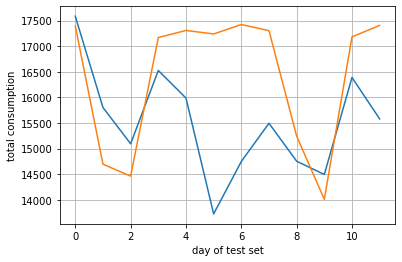

In [72]:
plt.figure()
plt.grid()
plt.plot(y_test.values)
plt.plot(final_predictions)
plt.xlabel('day of test set')
plt.ylabel('total consumption')
plt.show()

## Learning Curves

Come si vede nelle figure seguenti, il modello ETR gode di score migliori per questo dataset che per quello precedente, e questo probabilmente è dovuto alla ridotta dimensione delle features a loro volta sfoltite grazie alla PCA ed al whitening. Anche qui siamo ben lontani dalla convergenza.

<module 'matplotlib.pyplot' from '/usr/lib/python3.8/site-packages/matplotlib/pyplot.py'>

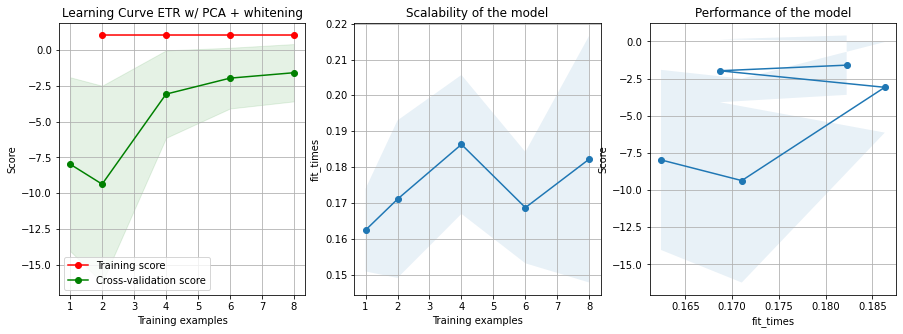

In [73]:
fig_lc2, axes_lc2 = plt.subplots(1, 3, figsize=(15, 5))

title = 'Learning Curve ETR w/ PCA + whitening'
X = tn_prepared
y = tn_labels
plot_learning_curve(final_model, title, X, y, axes=axes_lc2, cv=time_split, n_jobs=-1)

# Conclusioni

A partire dai dati preparati per la Provincia autonoma di Trento e per il Comune di Trento siamo riusciti, con un limitato successo, a stimare i consumi elettrici degli ultimi giorni di Dicembre dati i consumi elettrici del giorno precedente per cella geografica, i tweets, la temperatura, la precipitazione ed il vento. Evidentemente abbiamo una grossa limitazione che è la ridotta dimensione del campione $n$ rispetto alla numerosità delle features $p$.

Tuttavia attraverso l'uso di tecniche di Cross Validation siamo riusciti a sfoltire la selezione di modelli validi, comprendendo che una pregressa riduzione dimensionale con l'aiuto della PCA e del whitening ci può essere molto utile per mitigare gli effetti della multicollinearità e della condizione $p\gg n$, la cosiddetta [*curse of dimensionality*](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Machine_learning).

Nel nostro caso è stata la *sparsity* a salvarci, oltre anche alla cosiddetta *blessing of non-uniformity*. Siamo riusciti a trovare dei modelli che hanno comunque una certa capacità predittiva, anche se sicuramente sarebbe più opportuno per questo tipo di regressione avere a disposizione una maggiore quantità di dati.

Un ultimo commento sulle predizioni: come si vede evidentemente dai grafici, vi è una grossa discrepanza tra tutti i modelli e i consumi veri. Questa depressione dei consumi energetici le possiamo comprendere appieno se consideriamo che, avendo scelto un test set che costituisce il 20% di 60 giorni, i giorni in cui calano drasticamente i consumi corrispondono proprio al 23, 24, 25 e 26 Dicembre. È estremamente probabile che quindi la ricorrenza delle festività natalizie sia il fattore determinante.

# Riferimenti Bibliografici


*A Comprehensive Guide to Advanced Regression*. https://kaggle.com/eraaz1/a-comprehensive-guide-to-advanced-regression. Consultato 20 luglio 2020.

Dormann, Carsten F., et al. «Collinearity: A Review of Methods to Deal with It and a Simulation Study Evaluating Their Performance». *Ecography*, vol. 36, n. 1, gennaio 2013, pagg. 27–46. *DOI.org (Crossref)*, doi:10.1111/j.1600-0587.2012.07348.x.

*Feature selection — scikit-learn 0.23.1 documentation*. https://scikit-learn.org/stable/modules/feature\_selection.html. Consultato 20 luglio 2020.

Géron, Aurélien. *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*. 2019.

Gold, David. «Dealing With Multicollinearity: A Brief Overview and Introduction to Tolerant Methods». *Water Programming: A Collaborative Research Blog*, 23 febbraio 2017, https://waterprogramming.wordpress.com/2017/02/22/dealing-with-multicollinearity-a-brief-overview-and-introduction-to-tolerant-methods/.

Guyon, Isabelle, e André Elisseeff. *An introduction to variable and feature selection*. JMLR.org, 1 marzo 2003.

*In Depth: Principal Component Analysis | Python Data Science Handbook*. https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html. Consultato 20 luglio 2020.

«machine learning - What is the best way to go about feature selection (I am a beginner in ML)». *Cross Validated*, https://stats.stackexchange.com/questions/286666/what-is-the-best-way-to-go-about-feature-selection-i-am-a-beginner-in-ml. Consultato 20 luglio 2020.

*Multicollinearity in Regression*. https://stattrek.com/multiple-regression/multicollinearity.aspx. Consultato 20 luglio 2020.

Obozinski, Guillaume, et al. «Support Union Recovery in High-Dimensional Multivariate Regression». *Annals of Statistics*, vol. 39, n. 1, febbraio 2011, pagg. 1–47. *Project Euclid*, doi:10.1214/09-AOS776.

«pca - Regression in $p>n$ setting: how to choose regularization method (Lasso, PLS, PCR, ridge)?» *Cross Validated*, https://stats.stackexchange.com/questions/108614/regression-in-pn-setting-how-to-choose-regularization-method-lasso-pls-pc. Consultato 20 luglio 2020.

*Plotting Learning Curves — scikit-learn 0.23.1 documentation*. https://scikit-learn.org/stable/auto\_examples/model\_selection/plot\_learning\_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py. Consultato 20 luglio 2020.

«Should You Use Principal Component Regression?» *The DO Loop*, https://blogs.sas.com/content/iml/2017/10/25/principal-component-regression-drawbacks.html. Consultato 20 luglio 2020.

Tibshirani, Robert J. ["In praise of sparsity and convexity."](https://statweb.stanford.edu/~tibs/ftp/tibs-copss.pdf) Past, Present, and Future of Statistical Science. London: Chapman Hall (2014): 497-505.

*Unsupervised Feature Learning and Deep Learning Tutorial*. http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/. Consultato 20 luglio 2020.

*Whither the “bet on sparsity principle” in a nonsparse world? « Statistical Modeling, Causal Inference, and Social Science*. https://statmodeling.stat.columbia.edu/2013/12/16/whither-the-bet-on-sparsity-principle-in-a-nonsparse-world/. Consultato 20 luglio 2020.

*Why we hate stepwise regression « Statistical Modeling, Causal Inference, and Social Science*. https://statmodeling.stat.columbia.edu/2014/06/02/hate-stepwise-regression/. Consultato 20 luglio 2020.

Zou, Hui, e Trevor Hastie. «Regularization and Variable Selection via the Elastic Net». *Journal of the Royal Statistical Society: Series B (Statistical Methodology)*, vol. 67, n. 2, aprile 2005, pagg. 301–20. *DOI.org (Crossref)*, doi:10.1111/j.1467-9868.2005.00503.x.